In [70]:
import numpy as np

emission_data = np.load("emission_data_2021-2023.npy", allow_pickle=True)
zone_names = {-1: -1, 0:0, 1:1, 2:2, 3:3}
import datetime

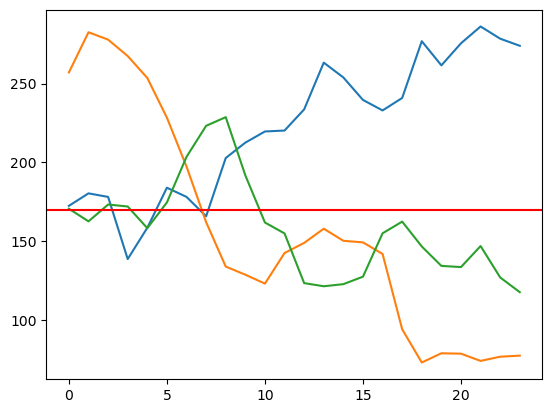

In [91]:
import matplotlib.pyplot as plt

idx_1 = 401
idx_2 = 1000
idx_3 = 1200

max_emission_value = 170

first_forecast = emission_data[idx_1 : idx_1 + 24]
second_forecast = emission_data[idx_2 : idx_2 + 24]
third_forecast = emission_data[idx_3 : idx_3 + 24]

forecasts = np.stack([first_forecast, second_forecast, third_forecast])

for forecast in forecasts:
    plt.plot(forecast)
plt.axhline(y=max_emission_value, c='r')

In [92]:
min_step_size = 2
max_window_size = 3
window_size = 0

time_slots = np.zeros((len(forecasts), 24))


for forecast_id, forecast in enumerate(forecasts):
    for window_size in range(max_window_size):
        for i in range(len(forecast)):
            co2_mean = forecast[i : i + min_step_size + window_size].mean()
            if co2_mean < max_emission_value:
                time_slots[forecast_id, i : i + min_step_size + window_size - 1] = 1
time_slots

array([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]])

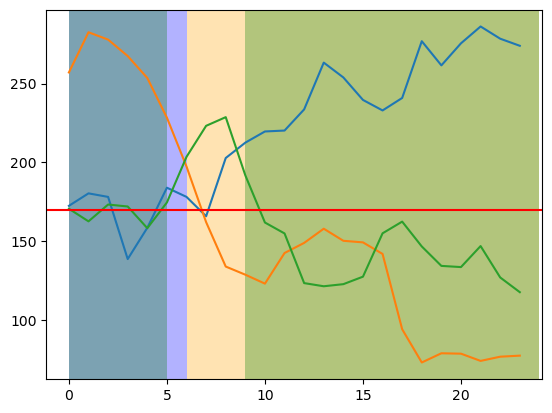

In [93]:
from matplotlib.patches import Rectangle

for forecast in forecasts:
    plt.plot(forecast)
plt.axhline(y=max_emission_value, c='r')

for i in range(len(time_slots[0])):
    if time_slots[0][i] == 1:
        plt.gca().add_patch(Rectangle((i,0),1,300, facecolor='blue', alpha=0.3 ))

for i in range(len(time_slots[1])):
    if time_slots[1][i] == 1:
        plt.gca().add_patch(Rectangle((i,0),1,300, facecolor='orange', alpha=0.3 ))

for i in range(len(time_slots[2])):
    if time_slots[2][i] == 1:
        plt.gca().add_patch(Rectangle((i,0),1,300, facecolor='green', alpha=0.3 ))


In [94]:
time_slots[:, 5:10]

array([[1., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1.]])

In [95]:
(time_slots[:, 10:15]==1).all(1) * 1e9

array([0.e+00, 1.e+09, 1.e+09])

In [96]:
# forecasts[(time_slots[:, 10:15]==1).all(1)]
forecasts

array([[172.5       , 180.41666667, 178.16666667, 138.75      ,
        158.58333333, 184.        , 178.16666667, 165.91666667,
        202.83333333, 212.58333333, 219.66666667, 220.25      ,
        233.66666667, 263.33333333, 253.91666667, 239.66666667,
        233.        , 240.91666667, 276.91666667, 261.58333333,
        275.58333333, 286.25      , 278.5       , 274.        ],
       [257.08333333, 282.58333333, 277.91666667, 267.5       ,
        253.58333333, 228.41666667, 197.41666667, 162.16666667,
        134.        , 128.83333333, 123.16666667, 142.58333333,
        149.        , 158.        , 150.33333333, 149.33333333,
        142.        ,  94.25      ,  73.16666667,  79.        ,
         78.75      ,  74.16666667,  76.83333333,  77.5       ],
       [170.66666667, 162.66666667, 173.33333333, 172.08333333,
        158.33333333, 174.66666667, 203.58333333, 223.25      ,
        228.75      , 191.83333333, 161.91666667, 155.        ,
        123.5       , 121.5       , 12

In [97]:
time_slots_vms = np.ones((24), dtype=int) * -1

i = 0
last_start_point = -1
while i + min_step_size < 24:
    if time_slots[:, i].sum() == 0:
        i += 1
        continue

    possible_vms = time_slots[:, i: i+min_step_size].all(1)
    if possible_vms.sum() == 1:
        time_slots_vms[i:i+min_step_size] = possible_vms.argmax()
        i += min_step_size
    else:
        co2_mean = forecasts[:, i : i + min_step_size].mean(axis=1)
        co2_mean += (~possible_vms) * 1e9
        min_co2_idx = co2_mean.argmin()
        time_slots_vms[i: i + min_step_size]= min_co2_idx
        i+=min_step_size

    


In [98]:
time_slots_vms

array([ 2,  2,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  1,
        1,  1,  1,  1,  1, -1, -1])

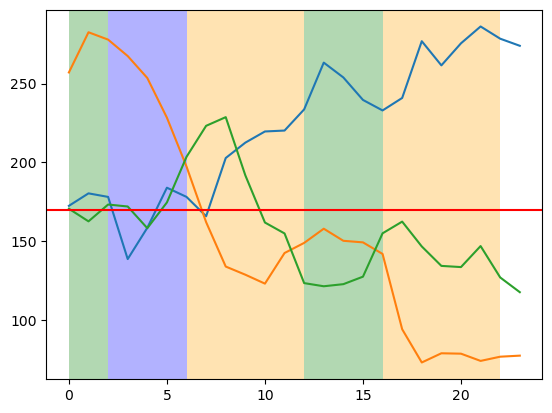

In [99]:
from matplotlib.patches import Rectangle

for forecast in forecasts:
    plt.plot(forecast)
plt.axhline(y=max_emission_value, c='r')

for i in range(len(time_slots[0])):
    if time_slots_vms[i] == 0:
        plt.gca().add_patch(Rectangle((i,0),1,300, facecolor='blue', alpha=0.3 ))
    elif time_slots_vms[i] == 1:
        plt.gca().add_patch(Rectangle((i,0),1,300, facecolor='orange', alpha=0.3 ))
    elif time_slots_vms[i] == 2:
        plt.gca().add_patch(Rectangle((i,0),1,300, facecolor='green', alpha=0.3 ))

In [100]:
current_vm = -1

intervals = {}
for time, vm in enumerate(time_slots_vms):
    if current_vm == -1:
        current_vm = vm
        start_time = time
    
    if vm != current_vm:
        end_time = time
        if current_vm in intervals.keys():
            intervals[current_vm].append((start_time, end_time))
        else:
            intervals[current_vm] = [(start_time, end_time)]
        current_vm = vm
        start_time = time

else:
    end_time = time
    if current_vm in intervals.keys():
        intervals[current_vm].append((start_time, end_time))
    else:
        intervals[current_vm] = [(start_time, end_time)]

del intervals[-1]


In [101]:
intervals

{2: [(0, 2), (12, 16)], 0: [(2, 6)], 1: [(6, 12), (16, 22)]}

In [102]:
ordered_intervals

[(2, (0, 2)),
 (0, (2, 4)),
 (2, (4, 6)),
 (0, (6, 8)),
 (1, (8, 12)),
 (2, (12, 16)),
 (1, (16, 22))]

In [103]:
ordered_intervals = [(k, intervals[k][i]) for k in intervals.keys() for i in range(len(intervals[k])) ]
ordered_intervals = sorted(ordered_intervals, key=lambda x: x[1][0])

formatted_intervals = [(ordered_intervals[0][0], [ordered_intervals[0][1]])]

for vm_idx, interval in ordered_intervals[1:]:
    if formatted_intervals[-1][0] == vm_idx:
        formatted_intervals[-1][1].append(interval)
    else:
        formatted_intervals.append((vm_idx, [interval]))

formatted_intervals

[(2, [(0, 2)]),
 (0, [(2, 6)]),
 (1, [(6, 12)]),
 (2, [(12, 16)]),
 (1, [(16, 22)])]

In [108]:
datetime_intervals = [
    (
        zone_names[vm_idx],
        [
            (
                datetime.datetime.now(datetime.timezone.utc).replace(
                    minute=0, second=0, microsecond=0
                )
                + datetime.timedelta(hours=int(jstart)),
                datetime.datetime.now(datetime.timezone.utc).replace(
                    minute=0, second=0, microsecond=0
                )
                + datetime.timedelta(hours=int(jend)),
            )
            for jstart, jend in vm_intervals
        ],
    )
    for vm_idx, vm_intervals in formatted_intervals
]

datetime_intervals


[(2,
  [(datetime.datetime(2023, 6, 28, 2, 0, tzinfo=datetime.timezone.utc),
    datetime.datetime(2023, 6, 28, 4, 0, tzinfo=datetime.timezone.utc))]),
 (0,
  [(datetime.datetime(2023, 6, 28, 4, 0, tzinfo=datetime.timezone.utc),
    datetime.datetime(2023, 6, 28, 8, 0, tzinfo=datetime.timezone.utc))]),
 (1,
  [(datetime.datetime(2023, 6, 28, 8, 0, tzinfo=datetime.timezone.utc),
    datetime.datetime(2023, 6, 28, 14, 0, tzinfo=datetime.timezone.utc))]),
 (2,
  [(datetime.datetime(2023, 6, 28, 14, 0, tzinfo=datetime.timezone.utc),
    datetime.datetime(2023, 6, 28, 18, 0, tzinfo=datetime.timezone.utc))]),
 (1,
  [(datetime.datetime(2023, 6, 28, 18, 0, tzinfo=datetime.timezone.utc),
    datetime.datetime(2023, 6, 29, 0, 0, tzinfo=datetime.timezone.utc))])]

In [83]:
datetime_intervals

[(2,
  [(datetime.datetime(2023, 6, 28, 2, 0, tzinfo=datetime.timezone.utc),
    datetime.datetime(2023, 6, 28, 4, 0, tzinfo=datetime.timezone.utc)),
   (datetime.datetime(2023, 6, 28, 6, 0, tzinfo=datetime.timezone.utc),
    datetime.datetime(2023, 6, 28, 8, 0, tzinfo=datetime.timezone.utc)),
   (datetime.datetime(2023, 6, 28, 14, 0, tzinfo=datetime.timezone.utc),
    datetime.datetime(2023, 6, 28, 18, 0, tzinfo=datetime.timezone.utc))]),
 (0,
  [(datetime.datetime(2023, 6, 28, 4, 0, tzinfo=datetime.timezone.utc),
    datetime.datetime(2023, 6, 28, 6, 0, tzinfo=datetime.timezone.utc)),
   (datetime.datetime(2023, 6, 28, 8, 0, tzinfo=datetime.timezone.utc),
    datetime.datetime(2023, 6, 28, 10, 0, tzinfo=datetime.timezone.utc))]),
 (1,
  [(datetime.datetime(2023, 6, 28, 10, 0, tzinfo=datetime.timezone.utc),
    datetime.datetime(2023, 6, 28, 14, 0, tzinfo=datetime.timezone.utc)),
   (datetime.datetime(2023, 6, 28, 18, 0, tzinfo=datetime.timezone.utc),
    datetime.datetime(2023, 6, 29